# AMISR Plotter

Hello! Welcome to my interactive plotting code. Here, you can produce Range-Time-Intensity (RTI) figures for long-pulse datafiles downloaded from "http://data.amisr.com" (RISR-N and PFISR data) and similarly structured long-pulse datafiles from "http://data.phys.ucalgary.ca/sort_by_project/RISR-C/calibrated_data/" (RISR-C data). The goal of this program is: 1) to let you plot AMISR data with the least amount of coding, and 2) be completely transparent in coding.

To start, please head to one of the two sites listed above, and grab a datafile. It must be in the same format as the example data files given in the "data" folder.

This next cell imports the libraries needed for plotting.

In [6]:
# IMPORT THE REQUIRED LIBRARIES (DO NOT TOUCH, UNLESS ALTERING THE CODE)
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import time

Once you have picked your datafile, fill in the following cell with your desired parameters. It is important to note that unless you are trying to develop a new code/type of figure THIS IS THE ONLY CELL YOU WILL NEED TO ALTER! You have been warned.

In [7]:
# CUSTOMIZE THE ALTITUDE SCALE (I RECOMMEND KEEPING BETWEEN 200 KM AND 400 KM)
alt_lowerlim = 200.
alt_upperlim = 400.

# CUSTOMIZE THE TIME SCALE. TO PRINT ALL TIMES, SET whole = 'y'
whole = 'y'
year_start = 2016
month_start = 1
day_start = 26
hour_start = 19
minute_start = 45
second_start = 0
year_end = 2016
month_end = 1
day_end = 26
hour_end = 23
minute_end = 0
second_end = 0

#SELECT THE BEAM YOU WISH TO PLOT
beam = 1

# CUSTOMIZE THE PLASMA/ELECTRON DENSITY SCALE [m-3 IN LOG SCALE] 
# (DATA WITH AN ERROR GREATER THAN THE MEASUREMENT ARE REMOVED)
nel_upperlim = 12
nel_lowerlim = 9

# CUSTOMIZE THE LINE-OF-SIGHT ION VELOCITY SCALE [m/s] 
# (DATA WITH AN ERROR GREATER THAN THE MEASUREMENT ARE KEPT SO DIFFUSION PROCESSES ARE VISIBLE)
losv_upperlim = 1000
losv_lowerlim = -1000

# CUSTOMIZE THE ELECTRON TEMPERATURE SCALE [K] 
# (DATA WITH AN ERROR GREATER THAN THE MEASUREMENT ARE REMOVED)
te_upperlim = 2500
te_lowerlim = 500

# CUSTOMIZE THE ION TEMPERATURE SCALE [K] 
# (POINTS WITH AN ERROR GREATER THAN THE MEASUREMENT ARE REMOVED)
ti_upperlim = 2500
ti_lowerlim = 500

# CUSTOMIZE THE PATH TO THE DATAFILE RELATIVE TO THE CODE
path = "C:/Users/Linds/Downloads/AMISR_plotting/data/"

# INSERT THE NAME OF THE h5 DATAFILE YOU HAVE DOWNLOADED AND WOULD LIKE TO PLOT
filename = "20190925.001_lp_5min.h5"

# THIS OPTION ALLOWS YOU TO SELECT THE COLOR SCALE YOU WOULD LIKE TO USE. 'jet' IS
# A COMMON OPTION, BUT IF YOU ARE COLOR BLIND YOU MAY CONSIDER 'viridis'
colorscale = 'jet'

From here, you just have to run the code. This next cell grabs everything we may need from the data file.

In [3]:
# THIS OPENS THE DATA FILE OF INTEREST
f  = h5.File(path+filename, 'r')

# BEAM PARAMETERS (E.G. ELEVATION ANGLE, AZIMUTH, ETC)
beamcodes = f['BeamCodes']
beamcodesdata = beamcodes[:,:]
beamcodesdata = beamcodesdata.astype(float)    

# EPOCH TIME
epoch = f['Time/UnixTime']
epochData = epoch[:,:]
epochData = epochData.astype(float)    

# ALTITUDE
alt = f['Geomag/Altitude']
altdata = alt[:,:]/1000.#CONVERTING FROM METERS TO KILOMETERS
altdata = altdata.astype(float)    

# PLASMA DENSITY [m-3]
ne = f['FittedParams/Ne']
nedata = ne[:,:,:]
nedata = nedata.astype(float)    

# ERROR IN PLASMA DENSITY [m-3]
dne = f['FittedParams/dNe']
dnedata = dne[:,:,:]
dnedata = dnedata.astype(float)    

# THE ION SPECIES IS SET
# 0 = O+, THE DOMINANT F-REGION ION. SOME DATAFILES OFFER, 1 = O2+, 2 = NO+ , 
# 3 = N2+ AND , 4 = N+, BUT I STRONGLY SUGGEST YOU DO NOT TOUCH THIS
ion = 0

# ION TEMPERATURE [K]
ti = f['FittedParams/Fits']
tidata = ti[:,:,:,ion,1]
tidata = tidata.astype(float)    

# ERROR IN ION TEMPERATURE [K]
dti = f['FittedParams/Errors']
dtidata = dti[:,:,:,ion,1]
dtidata = dtidata.astype(float)    

# ELECTRON TEMPERATURE [K]
te = f['FittedParams/Fits']
tedata = te[:,:,:,-1,1]  
tedata = tedata.astype(float)    

# ERROR IN ELECTRON TEMPERATURE [K]
dte = f['FittedParams/Errors']
dtedata = dte[:,:,:,-1,1]
dtedata = dtedata.astype(float)    

# LINE-OF-SIGHT ION VELOCITY [m/s]
losv = f['FittedParams/Fits']
losvdata = losv[:,:,:,ion,3]
losvdata = losvdata.astype(float)    

# CORRECTED GEOMAGNETIC LATITUDE [deg]
lat = f['Geomag/MagneticLatitude']
latdata = lat[:,:]
latdata = latdata.astype(float)       

# CORRECTED GEOMAGNETIC LONGITUDE [deg]
long = f['Geomag/MagneticLongitude']
longdata = long[:,:]
longdata = longdata.astype(float)  

# THIS CLOSES THE DATA FILE
f.close() 

This next cell generates a map of geomagnetic coordinates measured by the ISR. Note that this will only plot points within the altitude range you selected previously.

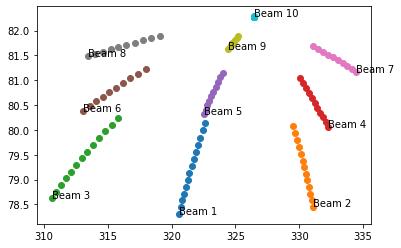

In [4]:
# THE 2D GEOMETRY OF THE BEAMS IN CORRECTED GEOMAGNETIC COORDINATES IS DRAWN 
for ii in range(len(longdata)):
  beamlat = []
  beamlong = []
  for jj in range(len(longdata[0])):  
    if alt_lowerlim < altdata[ii,jj] and altdata[ii,jj] < alt_upperlim:
      beamlat.extend([latdata[ii,jj]])
      if longdata[ii,jj] > 180:
        beamlong.extend([longdata[ii,jj]-360])
      if longdata[ii,jj] < 180:
        beamlong.extend([longdata[ii,jj]])
  plt.plot(beamlong,beamlat,'o')
  plt.text(beamlong[-1], beamlat[-1], 'Beam {}'.format(ii+1))

# THE X-AXIS IS ALTERED SO VALUES NEAR 0 AND 360 APPEAR SIDE-BY-SIDE
ax = plt.gca()
ticks, _ = plt.xticks()
for ii in range(len(ticks)):
  if ticks[ii] < 0:
    ticks[ii] = ticks[ii] + 360.
ax.set_xticklabels([int(tick) for tick in ticks])

# THIS SHOWS THE FIGURE
plt.show()

Finally, this is the cell where the RTI figure is created. It is a little sluggish, but does the trick!

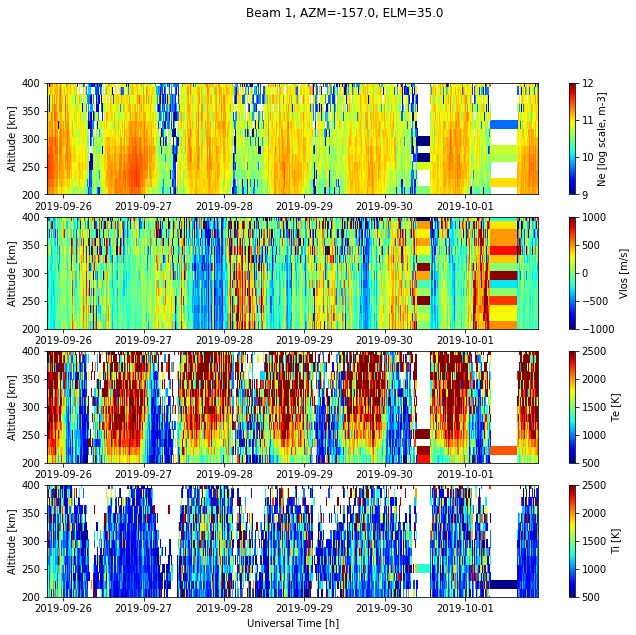

In [5]:
# THIS CONVERTS EPOCH TIME TO UNIVERSAL TIME IN DATETIME
ut = [datetime.datetime(int(time.gmtime((epochData[t,0]+epochData[t,1])/2)[0]), # YEAR
                       int(time.gmtime((epochData[t,0]+epochData[t,1])/2)[1]), # MONTH
                       int(time.gmtime((epochData[t,0]+epochData[t,1])/2)[2]), # DAY
                       int(time.gmtime((epochData[t,0]+epochData[t,1])/2)[3]), # HOUR
                       int(time.gmtime((epochData[t,0]+epochData[t,1])/2)[4]), # MINUTE
                       int(time.gmtime((epochData[t,0]+epochData[t,1])/2)[5])) # SECOND
                       for t in range(len(epochData))]

# THIS CONVERTS THE TIME LIMITS GIVEN INTO DATETIME
time_lowerlim = datetime.datetime(int(year_start), 
                                  int(month_start), 
                                  int(day_start), 
                                  int(hour_start), 
                                  int(minute_start), 
                                  int(second_start))  
time_upperlim = datetime.datetime(int(year_end), 
                                  int(month_end), 
                                  int(day_end), 
                                  int(hour_end), 
                                  int(minute_end), 
                                  int(second_end))  

# IF whole = 'y', ALL TIMES ARE OUTPUTTED
if whole == 'y':
  time_lowerlim = datetime.datetime(int(time.gmtime((epochData[0,0]+epochData[0,1])/2)[0]),
                                    int(time.gmtime((epochData[0,0]+epochData[0,1])/2)[1]), 
                                    int(time.gmtime((epochData[0,0]+epochData[0,1])/2)[2]), 
                                    int(time.gmtime((epochData[0,0]+epochData[0,1])/2)[3]), 
                                    int(time.gmtime((epochData[0,0]+epochData[0,1])/2)[4]), 
                                    int(time.gmtime((epochData[0,0]+epochData[0,1])/2)[5]))  
  time_upperlim = datetime.datetime(int(time.gmtime((epochData[-1,0]+epochData[-1,1])/2)[0]), 
                                    int(time.gmtime((epochData[-1,0]+epochData[-1,1])/2)[1]), 
                                    int(time.gmtime((epochData[-1,0]+epochData[-1,1])/2)[2]), 
                                    int(time.gmtime((epochData[-1,0]+epochData[-1,1])/2)[3]), 
                                    int(time.gmtime((epochData[-1,0]+epochData[-1,1])/2)[4]), 
                                    int(time.gmtime((epochData[-1,0]+epochData[-1,1])/2)[5]))  

# ERRONEOUS POINTS ARE REMOVED (COMMENT THIS OUT TO VIEW ALL MEASUREMENTS)
for tt in range(len(nedata)):
  for ii in range(len(nedata[0])):
    for jj in range(len(nedata[0,0])):
      if nedata[tt,ii,jj] < dnedata[tt,ii,jj]:
        nedata[tt,ii,jj] = np.NaN
      if tidata[tt,ii,jj] < dtidata[tt,ii,jj]:
        tidata[tt,ii,jj] = np.NaN
      if tedata[tt,ii,jj] < dtedata[tt,ii,jj]:
        tedata[tt,ii,jj] = np.NaN

# THIS ESTABLISHES THE SIZE AND LOCATION OF THE DIFFERENT SUBPLOTS
gridsize = (4, 1)
fig = plt.figure(figsize=(11,10.5))
plt.gcf().autofmt_xdate()  
fig.suptitle('Beam {}, Azimuth Angle={}, Elevation Angle={}'.format(beam,beamcodesdata[beam-1,1],beamcodesdata[beam-1,2]))
ax1 = plt.subplot2grid(gridsize, (0,0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1,0), colspan=1, rowspan=1)
ax3 = plt.subplot2grid(gridsize, (2,0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid(gridsize, (3,0), colspan=1, rowspan=1)

# A ROTATION IS PERFORMED SO THAT TIME IS ON THE X-AXIS AND ALTITUDE IS ON THE Y-AXIS
z1 = np.transpose(nedata[:,beam-1,:])
z2 = np.transpose(losvdata[:,beam-1,:])
z3 = np.transpose(tedata[:,beam-1,:])
z4 = np.transpose(tidata[:,beam-1,:])

# A LOG BASE 10 IS APPLIED TO THE PLASMA DENSITY
for t in range(len(z1)):
  for j in range(len(z1[0])):
    if z1[t,j] > 0.001:
      z1[t,j] = math.log(z1[t,j],10)

# THE ELECTRON DENSITY IS PLOTTED
c1 = ax1.pcolor(ut, altdata[beam-1,:], z1, cmap=colorscale, vmin=nel_lowerlim, vmax=nel_upperlim)
# THE LINE-OF-SIGHT ION VELOCITY IS PLOTTED
c2 = ax2.pcolor(ut, altdata[beam-1,:], z2, cmap=colorscale, vmin=losv_lowerlim, vmax=losv_upperlim)
# THE ELECTRON TEMPERATURE IS PLOTTED
c3 = ax3.pcolor(ut, altdata[beam-1,:], z3, cmap=colorscale, vmin=te_lowerlim, vmax=te_upperlim)
# THE ION TEMPERATURE IS PLOTTED
c4 = ax4.pcolor(ut, altdata[beam-1,:], z4, cmap=colorscale, vmin=ti_lowerlim, vmax=ti_upperlim)

# X-AXIS LABEL (TO SAVE SPACE, I AM ONLY LABELLING THE LOWEST PANEL)
ax4.set_xlabel('Universal Time [h]')

# Y-AXIS LABELS 
ax1.set_ylabel('Altitude [km]')
ax2.set_ylabel('Altitude [km]')
ax3.set_ylabel('Altitude [km]')
ax4.set_ylabel('Altitude [km]')

# COLORBARS ARE SET
fig.colorbar(c1, ax=ax1, label='Ne [log scale, m-3]')
fig.colorbar(c2, ax=ax2, label='Vlos [m/s]')
fig.colorbar(c3, ax=ax3, label='Te [K]')
fig.colorbar(c4, ax=ax4, label='Ti [K]')  

# THE ALTITUDE RANGE IS SET
ax1.set_ylim(alt_lowerlim,alt_upperlim)
ax2.set_ylim(alt_lowerlim,alt_upperlim)
ax3.set_ylim(alt_lowerlim,alt_upperlim)
ax4.set_ylim(alt_lowerlim,alt_upperlim)
  
# THE TIME RANGE IS SET  
ax1.set_xlim(time_lowerlim,time_upperlim)
ax2.set_xlim(time_lowerlim,time_upperlim)
ax3.set_xlim(time_lowerlim,time_upperlim)
ax4.set_xlim(time_lowerlim,time_upperlim)
  
# THIS SHOWS THE FIGURE
plt.show()

The white spaces are missing or erroneous data. "Smearing" is a result of a lapse in radar data.